In [1]:
import math

import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] =  [r'\usepackage{libertine}', r'\usepackage{newtxmath}'] 
mpl.rc('font', family='serif')

import numpy as np
import pandas as pd
import seaborn as sns
import copy

import matplotlib.pyplot as plt
from matplotlib import rc

from cycler import cycler

from scipy.interpolate import make_interp_spline, BSpline

mpl.rcParams['ps.usedistiller'] = 'xpdf' 

plt.style.use('seaborn-notebook')

plt.rcParams['axes.titlesize'] = '25'
plt.rcParams['axes.labelsize'] = '25'
plt.rcParams['legend.fontsize'] = '15'
plt.rcParams['xtick.labelsize'] = '18'
plt.rcParams['ytick.labelsize'] = '18'

monochrome=(cycler('color', sns.color_palette("husl", 8))*2+(cycler('marker', ['v', 's', "o"])*7)[0:16])
plt.rc('axes', prop_cycle=monochrome)

pd.options.display.max_rows = 999
pd.options.display.max_columns = None
cmap = cm.get_cmap('RdBu')

husl4 = sns.color_palette("husl", 4)
husl5 = sns.color_palette("husl", 5)
husl6 = sns.color_palette("husl", 7)
greens5 = sns.color_palette("Greens_r", 5)
purples5 = sns.color_palette("Purples_r", 7)
blues5 = sns.color_palette("Blues_r", 5)
reds5 = sns.color_palette("Reds_r", 8)
oranges5 = sns.color_palette("Oranges_r", 5)
greys5 = sns.color_palette("Greys_r", 5)
winter5 = sns.color_palette("viridis_r", 5)

In [2]:
folder = "2020-04-24-09-40_SGMRDsearchers_pi_" # Replace 

In [3]:
summary = pd.read_csv("../experiments/" + folder + "/SGMRDsearchers_pi.csv", dtype={"searched": "str"})

In [4]:
refdata = pd.read_csv("../experiments/2020-04-24-12-07_SGMRDsearchers_gold/SGMRDsearchers_gold.csv", dtype={"searched": "str"})
refdata["successpercent"] = [x/y if y>0 else None for x,y in zip(refdata["success"],refdata["ntried"])]
ref = refdata["avgContrast"]
refsuccess = refdata["successpercent"]

In [5]:
# some cleaning
summary["searched"] = summary["searched"].fillna("")
summary["searched"] =  [x[:-2] if x[-2:] == ".0" else x for x in summary["searched"]]

summary["nsearched"] = [len(x.split("-")) if not pd.isna(x) else 0 for x in summary["searched"] ]
del summary["n"]
del summary["nDim"]

summary["successpercent"] = [x/y if y>0 else None for x,y in zip(summary["success"],summary["ntried"])]

summary["strategy"] = [x.split("-")[3] for x in summary["searcherID"]]
summary["step"] = [x.split("-")[-4] for x in summary["searcherID"]]

summary["time"] = summary["indextime"] + summary["decisiontime"] + summary["searchtime"]

In [6]:
summary.head(5)

,refId,refCategory,searcherID,searched,ntried,success,indextime,monitortime,decisiontime,searchtime,nSubspaces,avgSubspaceLength,avgContrast,i,rep,nsearched,successpercent,strategy,step,time
0,b_1dx100_s,real,SGMRD-KSP-0.9-Worst-1-1000-5-0-1-1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,460.2254,0.0,0.0,800015.0526,100,3.41,0.9889,0,0,100,0.0,Worst,5,800475.2780
1,b_1dx100_s,real,SGMRD-KSP-0.9-MPTS-1-0.0-1000-20-0-1-1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,458.0917,0.0,0.0,799549.1636,100,3.40,0.9936,0,0,100,0.0,MPTS,20,800007.2553
2,b_1dx100_s,real,SGMRD-KSP-0.9-MPTS-1-0.0-1000-50-0-1-1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,363.7274,0.0,0.0,801604.1908,100,3.49,0.9926,0,0,100,0.0,MPTS,50,801967.9182
3,b_1dx100_s,real,SGMRD-KSP-0.9-MPTS-1-0.0-1000-5-0-1-1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,372.4079,0.0,0.0,802384.5359,100,3.66,0.9916,0,0,100,0.0,MPTS,5,802756.9438
4,b_1dx100_s,real,SGMRD-KSP-0.9-Worst-1-1000-2-0-1-1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,425.9186,0.0,0.0,803178.3656,100,3.47,0.9884,0,0,100,0.0,Worst,2,803604.2842


# Figure 7

In [7]:
searchers = summary["searcherID"].unique()

In [8]:
selected_searcher = [
                     'SGMRD-KSP-0.9-MPTS-1-0.0-1000-2-0-1-1',
                     'SGMRD-KSP-0.9-RD-1-1000-2-0-1-1',
                     'SGMRD-KSP-0.9-Worst-1-1000-2-0-1-1',
                     'SGMRD-KSP-0.9-All-1000-1000-0-1-1',
                     'SGMRD-KSP-0.9-None-1000-1-0-1-1',
                    ]

In [9]:
prettynames = {
    'SGMRD-KSP-0.9-All-1000-1000-0-1-1': "Batch",
    'SGMRD-KSP-0.9-Worst-1-1000-1-0-1-1': "SGMRD-GD",
    'SGMRD-KSP-0.9-RD-1-1000-1-0-1-1': "SGMRD-RD",
    'SGMRD-KSP-0.9-None-1000-1-0-1-1': "Init",
    'SGMRD-KSP-0.9-MPTS-1-0.0-1000-1-0-1-1': "SGMRD-TS",
    
    'SGMRD-KSP-0.9-Worst-1-1000-10-0-1-1': "SGMRD-GD",
    'SGMRD-KSP-0.9-RD-1-1000-10-0-1-1': "SGMRD-RD",
    'SGMRD-KSP-0.9-None-1000-10-0-1-1': "Init",
    'SGMRD-KSP-0.9-MPTS-1-0.0-1000-10-0-1-1': "SGMRD-TS",
    
    'SGMRD-KSP-0.9-Worst-1-1000-2-0-1-1': "SGMRD-GD",
    'SGMRD-KSP-0.9-RD-1-1000-2-0-1-1': "SGMRD-RD",
    'SGMRD-KSP-0.9-None-1000-2-0-1-1': "Init",
    'SGMRD-KSP-0.9-MPTS-1-0.0-1000-2-0-1-1': "SGMRD-TS",
}

styledictionary = {
    
    "Batch": {'marker': 'o', 'color': reds5[0], 'linestyle': "--"},
    "SGMRD-GD": {'marker': '^', 'color': blues5[2], 'linestyle': "-"},
    "SGMRD-RD": {'marker': 's', 'color': purples5[1], 'linestyle': "-"},
    "Init": {'marker': 'D', 'color': greens5[0], 'linestyle': "--"},
    "SGMRD-TS": {'marker': 'X', 'color': oranges5[0], 'linestyle': "-"},
    
    "GD": {'marker': '^', 'color': blues5[2], 'linestyle': "-"},
    "RD": {'marker': 's', 'color': purples5[1], 'linestyle': "-"},
    "TS": {'marker': 'X', 'color': oranges5[0], 'linestyle': "-"},
}

<IPython.core.display.Javascript object>


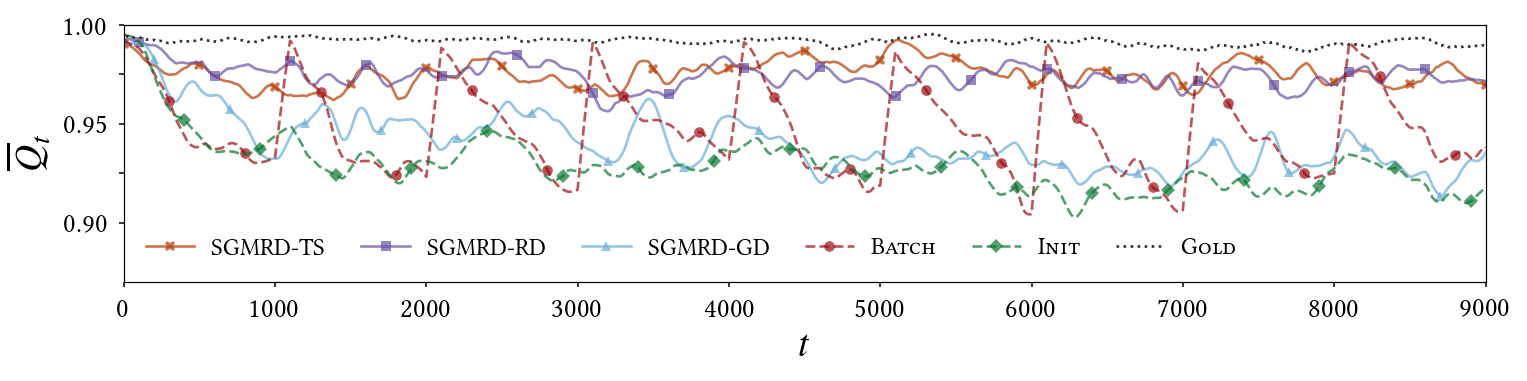

In [10]:
%matplotlib notebook

f, axarr = plt.subplots(1,1, figsize=(14,3.5))

dataset = "b_1dx100_s"
i = 0
for searcher in selected_searcher: #searchers[:1]:
    subdata = summary[(summary["searcherID"] == searcher) & (summary["refId"] == dataset)]
    toplot = subdata["avgContrast"].reset_index(drop=True).rolling(
        window=100, min_periods=1).mean()
    toplot.plot(marker=styledictionary[prettynames[searcher]]["marker"], 
                linestyle=styledictionary[prettynames[searcher]]["linestyle"], 
                label=r'\textsc{%s}'%prettynames[searcher],
                color=styledictionary[prettynames[searcher]]["color"], 
                alpha=0.7,
               markevery=(i*100, 500))
    i += 1
ref.rolling(window=100, min_periods=1).mean().plot(marker="", linestyle=":", label=r'\textsc{Gold}', color=greys5[0])

plt.ylabel("$\overline{Q}_t$")
plt.xlabel("$t$")
plt.ylim((0.87, 1))
plt.yticks([0.9, 0.925, 0.95, 0.975, 1], ["0.90", "", "0.95", "", "1.00"])

plt.legend(fontsize=16, loc="lower left", ncol=6, handletextpad=0.7, columnspacing=1.5, framealpha=0)

plt.tight_layout()
plt.savefig("plots/Figure7.pdf")

# Figure 10

In [13]:
# This one requires some more repetitions 
summary = pd.read_csv("../experiments/" + folder + "/SGMRDsearchers_pi.csv", dtype={"searched": "str"})
summary2 = pd.read_csv("../experiments/2020-05-06-14-42_SGMRDsearchers_reps_/SGMRDsearchers_reps.csv", dtype={"searched": "str"})
summary3 = pd.read_csv("../experiments/2020-05-07-19-18_SGMRDsearchers_reps_/SGMRDsearchers_reps.csv", dtype={"searched": "str"})

summary = pd.concat([summary, summary2, summary3])

# some cleaning
summary["searched"] = summary["searched"].fillna("")
summary["searched"] =  [x[:-2] if x[-2:] == ".0" else x for x in summary["searched"]]

summary["nsearched"] = [len(x.split("-")) if not pd.isna(x) else 0 for x in summary["searched"] ]
del summary["n"]
del summary["nDim"]

summary["successpercent"] = [x/y if y>0 else None for x,y in zip(summary["success"],summary["ntried"])]

summary["strategy"] = [x.split("-")[3] for x in summary["searcherID"]]
summary["step"] = [x.split("-")[-4] for x in summary["searcherID"]]

summary["time"] = summary["indextime"] + summary["decisiontime"] + summary["searchtime"]

In [14]:
def func(x, a, b, c):
     return a + b * x**(-c)

In [15]:
from scipy.interpolate import make_interp_spline, BSpline

In [16]:
markevery = [0,int(299*0.02),int(299*0.05),int(299*0.10),int(299*0.20),int(299*0.50),299]

In [17]:
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit

In [18]:
cor = {
    "MPTS": "TS" , 
    "RD": "RD", 
    "Worst": "GD", 
    "All": "Batch", 
    "None": "Init"
}

<IPython.core.display.Javascript object>


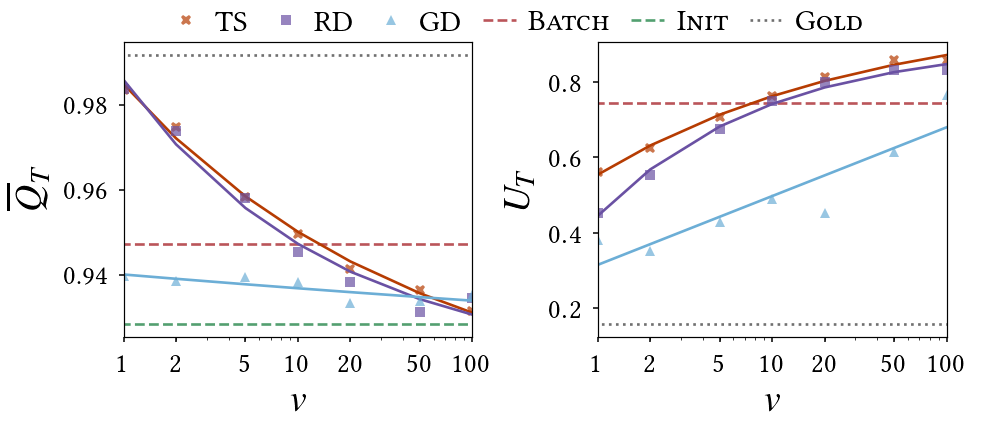

In [19]:
f, axarr = plt.subplots(1,2, figsize=(9,4), gridspec_kw={'width_ratios': [1, 1]}, sharex=True, sharey=False)
axes = axarr.flatten()

dataset = "b_1dx100_s"

plt.sca(axes[0])

strategies = ["MPTS", "RD", "Worst"]

for strategy in strategies:
    subdata = summary[summary["strategy"] == strategy]
    toplot = subdata.groupby(["step"]).mean().reset_index()
    toplot["step"] = toplot["step"].astype("float")
    toplot = toplot.sort_values("step")
    
    toplot.plot(x= "step", y = "avgContrast", ax=plt.gca(), label=r'\textsc{%s}'%cor[strategy],
                marker=styledictionary[cor[strategy]]["marker"],  
                color=styledictionary[cor[strategy]]["color"], 
                alpha=0.7, linestyle="")    

    
    popt, pcov = curve_fit(func, toplot["step"], toplot["avgContrast"], p0=[1,0,1], maxfev=5000)
    plt.plot(toplot["step"], func(toplot["step"], popt[0], popt[1], popt[2]), 'r-', 
             color=styledictionary[cor[strategy]]["color"], label='_nolegend_')
    
globalstrategies = ["All", "None"]

for strategy in globalstrategies:
    subdata = summary[summary["strategy"] == strategy]
    toplot = subdata.groupby(["step"]).mean().reset_index()
    toplot["step"] = toplot["step"].astype("float")
    plt.hlines(toplot["avgContrast"].values[0], xmin=0, xmax=100, 
               label=r'\textsc{%s}'%cor[strategy],
               linestyle=styledictionary[cor[strategy]]["linestyle"], 
               color=styledictionary[cor[strategy]]["color"], 
               alpha=0.7)
    
    
    
plt.hlines(ref.mean(),  xmin=0, xmax=100, label=r'\textsc{Gold}', 
          linestyle=":", 
          color=greys5[0],
          alpha=0.7)
    
plt.legend(ncol=6, loc=1, bbox_to_anchor=(2.2,1.2), fontsize=20, handletextpad=0.4,  handlelength=1.1, columnspacing=0.7, framealpha=0)
    
plt.ylabel("$\overline{Q}_T$")
plt.xlabel("$v$")
plt.xticks([1,2,5,10,20,50,100], [1,2,5,10,20,50,100])
plt.yticks([0.94,0.96,0.98], ["0.94","0.96","0.98"])
plt.xlim(-1,100)

plt.sca(axes[1])

for strategy in strategies:
    subdata = summary[summary["strategy"] == strategy]
    toplot = subdata.groupby(["step"]).mean().reset_index()
    toplot["step"] = toplot["step"].astype("float")
    toplot = toplot.sort_values("step")
    
    toplot.plot(x= "step", y = "successpercent", ax=plt.gca(), label=r'\textsc{%s}'%cor[strategy],
                marker=styledictionary[cor[strategy]]["marker"], 
                color=styledictionary[cor[strategy]]["color"], 
                alpha=0.7,
                linestyle="")    
    
    popt, pcov = curve_fit(func, toplot["step"], toplot["successpercent"], p0=[1,0,1], maxfev=5000)
    plt.plot(toplot["step"], func(toplot["step"], popt[0], popt[1], popt[2]), 'r-', 
             color=styledictionary[cor[strategy]]["color"], label='_nolegend_')
    
globalstrategies = ["All"]

for strategy in globalstrategies:
    subdata = summary[summary["strategy"] == strategy]
    toplot = subdata.groupby(["step"]).mean().reset_index()
    toplot["step"] = toplot["step"].astype("float")
    plt.hlines(toplot["successpercent"].values[0], xmin=0, xmax=100, 
               label=r'\textsc{%s}'%cor[strategy],
               linestyle=styledictionary[cor[strategy]]["linestyle"], 
               color=styledictionary[cor[strategy]]["color"], 
               alpha=0.7
              )
    
plt.hlines(refsuccess.mean(),  xmin=0, xmax=100, label=r'\textsc{Gold}', 
          linestyle=":", 
          color=greys5[0],
          alpha=0.7)
    
    
legend = plt.gca().legend()
legend.remove()
    
plt.xscale("log")

plt.ylabel("$U_T$")
plt.xlabel("$v$")
plt.xticks([1,2,5,10,20,50,100], [1,2,5,10,20,50,100])
plt.xlim(-1,100)
plt.tight_layout()

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig("plots/Figure10.pdf")

# Figure 8

In [20]:
selected_searcher = [
                     'SGMRD-KSP-0.9-MPTS-1-0.0-1000-2-0-1-1',
                     'SGMRD-KSP-0.9-RD-1-1000-2-0-1-1',
                     'SGMRD-KSP-0.9-Worst-1-1000-2-0-1-1',
                     'SGMRD-KSP-0.9-All-1000-1000-0-1-1',
                     'SGMRD-KSP-0.9-None-1000-1-0-1-1',
                    ]

In [21]:
customsearchers = [x for x in summary["searcherID"].unique() if ("MPTS" in x) or ("RD" in x)]
customsearchers = [x for x in customsearchers if (x.split("-")[-4] != "50") and (x.split("-")[-4] != "100")]

In [22]:
customsearchers = [
 'SGMRD-KSP-0.9-MPTS-1-0.0-1000-1-0-1-1',
 'SGMRD-KSP-0.9-RD-1-1000-1-0-1-1',

 'SGMRD-KSP-0.9-MPTS-1-0.0-1000-2-0-1-1',
 'SGMRD-KSP-0.9-RD-1-1000-2-0-1-1',
    
 'SGMRD-KSP-0.9-MPTS-1-0.0-1000-5-0-1-1',    
 'SGMRD-KSP-0.9-RD-1-1000-5-0-1-1',

 'SGMRD-KSP-0.9-MPTS-1-0.0-1000-10-0-1-1',
 'SGMRD-KSP-0.9-RD-1-1000-10-0-1-1',
    
 'SGMRD-KSP-0.9-MPTS-1-0.0-1000-20-0-1-1',
 'SGMRD-KSP-0.9-RD-1-1000-20-0-1-1',
]

In [23]:
purples5 = sns.color_palette("Purples_r", 7)
oranges5 = sns.color_palette("Oranges_r", 5)

cubelix7 = sns.color_palette("cubehelix", 7)

prettynames2 = {
    'SGMRD-KSP-0.9-MPTS-1-0.0-1000-1-0-1-1': "SGMRD-TS, $v=1$",
    'SGMRD-KSP-0.9-MPTS-1-0.0-1000-2-0-1-1': "SGMRD-TS, $v=2$",
    'SGMRD-KSP-0.9-MPTS-1-0.0-1000-5-0-1-1': "SGMRD-TS, $v=5$",
    'SGMRD-KSP-0.9-MPTS-1-0.0-1000-10-0-1-1': "SGMRD-TS, $v=10$",
    'SGMRD-KSP-0.9-MPTS-1-0.0-1000-20-0-1-1': "SGMRD-TS, $v=20$",
    'SGMRD-KSP-0.9-MPTS-1-0.0-1000-50-0-1-1': "SGMRD-TS, $v=50$",
    'SGMRD-KSP-0.9-MPTS-1-0.0-1000-100-0-1-1': "SGMRD-TS, $v=100$",
    
    'SGMRD-KSP-0.9-RD-1-1000-1-0-1-1': "SGMRD-RD, $v=1$",
    'SGMRD-KSP-0.9-RD-1-1000-2-0-1-1': "SGMRD-RD, $v=2$",
    'SGMRD-KSP-0.9-RD-1-1000-5-0-1-1': "SGMRD-RD, $v=5$",
    'SGMRD-KSP-0.9-RD-1-1000-10-0-1-1': "SGMRD-RD, $v=10$",
    'SGMRD-KSP-0.9-RD-1-1000-20-0-1-1': "SGMRD-RD, $v=20$",
    'SGMRD-KSP-0.9-RD-1-1000-50-0-1-1': "SGMRD-RD, $v=50$",
    'SGMRD-KSP-0.9-RD-1-1000-100-0-1-1': "SGMRD-RD, $v=100$",
}

styledictionary2 = {
    "SGMRD-RD, $v=1$": {'marker': 's', 'color': cubelix7[0], 'linestyle': "--"},
    "SGMRD-TS, $v=1$": {'marker': 'X', 'color': cubelix7[0], 'linestyle': "-"},
    "SGMRD-RD, $v=2$": {'marker': 's', 'color': cubelix7[1], 'linestyle': "--"},
    "SGMRD-TS, $v=2$": {'marker': 'X', 'color': cubelix7[1], 'linestyle': "-"},
    "SGMRD-RD, $v=5$": {'marker': 's', 'color': cubelix7[2], 'linestyle': "--"},
    "SGMRD-TS, $v=5$": {'marker': 'X', 'color': cubelix7[2], 'linestyle': "-"},
    "SGMRD-RD, $v=10$": {'marker': 's', 'color': cubelix7[3], 'linestyle': "--"},
    "SGMRD-TS, $v=10$": {'marker': 'X', 'color': cubelix7[3], 'linestyle': "-"},
    "SGMRD-RD, $v=20$": {'marker': 's', 'color': cubelix7[4], 'linestyle': "--"},
    "SGMRD-TS, $v=20$": {'marker': 'X', 'color': cubelix7[4], 'linestyle': "-"},

    "SGMRD-RD, $v=50$": {'marker': 's', 'color': cubelix7[1], 'linestyle': "--"},
    "SGMRD-TS, $v=50$": {'marker': 'X', 'color': cubelix7[1], 'linestyle': "-"},
    "SGMRD-RD, $v=100$": {'marker': 's', 'color': cubelix7[2], 'linestyle': "--"},
    "SGMRD-TS, $v=100$": {'marker': 'X', 'color': cubelix7[2], 'linestyle': "-"},
}

<IPython.core.display.Javascript object>


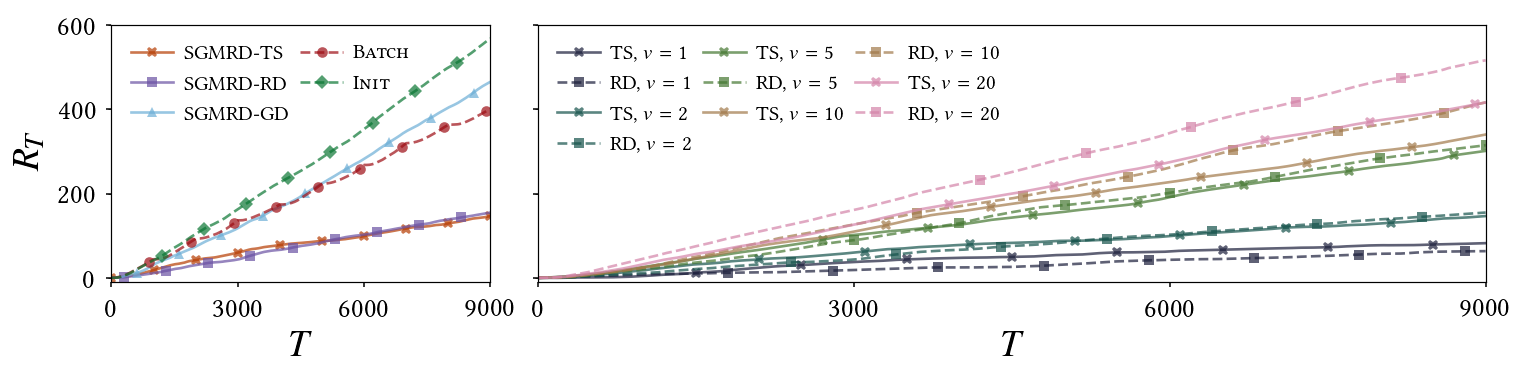

(63007, 20)
(63007, 20)
(63007, 20)
(9001, 20)
(9001, 20)
(63007, 20)
(63007, 20)
(63007, 20)
(63007, 20)
(63007, 20)
(63007, 20)
(63007, 20)
(63007, 20)
(63007, 20)
(63007, 20)


In [24]:
%matplotlib notebook

f, axarr = plt.subplots(1,2, figsize=(14,3.5), gridspec_kw={'width_ratios': [2, 5]}, sharex=True, sharey='row')
axes = axarr.flatten()

dataset = "b_1dx100_s"

plt.sca(axes[0])
i = 0
for searcher in selected_searcher: #searchers[:1]:
    subdata = summary[(summary["searcherID"] == searcher) & (summary["refId"] == dataset)]
    print(subdata.shape)
    toplot = (ref- subdata["avgContrast"].reset_index(drop=True))#.rolling(window=100, min_periods=1).mean()
    toplot.cumsum().plot(marker=styledictionary[prettynames[searcher]]["marker"], 
                linestyle=styledictionary[prettynames[searcher]]["linestyle"], 
                label=r'\textsc{%s}'%prettynames[searcher],
                         color=styledictionary[prettynames[searcher]]["color"], 
                         alpha=0.7,
               markevery=(i*300, 1000))
    i += 1

plt.ylabel("$R_T$")
plt.xlabel("$T$")
plt.ylim((-10, 600))
plt.xticks([0,3000,6000,9000], [0,3000,6000,9000])
plt.xlim(0,9000)

plt.legend(fontsize=14, loc="upper left", ncol=2, handletextpad=0.5, columnspacing=0.5, framealpha=0)


plt.sca(axes[1])

for searcher in customsearchers: #searchers[:1]:
    subdata = summary[(summary["searcherID"] == searcher) & (summary["refId"] == dataset)]
    print(subdata.shape)
    toplot = (ref- subdata["avgContrast"].reset_index(drop=True))
    toplot.cumsum().plot(marker=styledictionary2[prettynames2[searcher]]["marker"], 
                linestyle=styledictionary2[prettynames2[searcher]]["linestyle"], 
                label=r'\textsc{%s}'%prettynames2[searcher][6:],
                         color=styledictionary2[prettynames2[searcher]]["color"], 
                         alpha=0.7,
               markevery=(i*300, 1000))
    i += 1
plt.ylabel("$R_T$")
plt.xlabel("$T$")
plt.ylim((-10, 600))
plt.xticks([0,3000,6000,9000], [0,3000,6000,9000])
plt.xlim(0,9000)

plt.legend(fontsize=14, loc="upper left", ncol=3, handletextpad=0.5, columnspacing=0.5, framealpha=0)

plt.tight_layout()
plt.savefig("plots/Figure8.pdf")

# Figure 9 

<IPython.core.display.Javascript object>


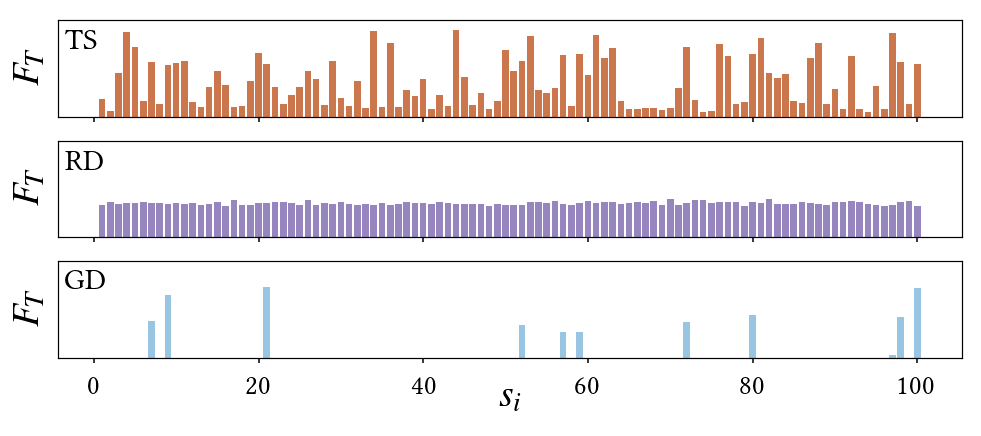

In [25]:
%matplotlib notebook

f, axarr = plt.subplots(3,1, figsize=(9,4), sharex=True, sharey='row')
axes = axarr.flatten()

plt.sca(axes[0])
counts = dict()
searcher = 'SGMRD-KSP-0.9-MPTS-1-0.0-1000-1-0-1-1'
for x in summary[summary["searcherID"] == searcher]["searched"]:
    if not pd.isna(x):
        y = [int(z) for z in x.split("-")]
        for k in y:
            if(counts.get(k) is None):
                counts[k] = 1
            else:
                counts[k] = counts[k] + 1
plt.bar([x+1 for x in counts.keys()], [x/9000 for x in counts.values()], 
        color=styledictionary[prettynames[searcher]]["color"], alpha=0.7)
plt.text(-3.5, 0.14, "TS", fontsize=20)

plt.ylim(0,0.2)
plt.yticks([], [])
plt.ylabel("$F_T$")

plt.sca(axes[1])
counts = dict()
searcher = 'SGMRD-KSP-0.9-RD-1-1000-1-0-1-1' 
for x in summary[summary["searcherID"] == searcher]["searched"]:
    if not pd.isna(x):
        y = [int(z) for z in x.split("-")]
        for k in y:
            if(counts.get(k) is None):
                counts[k] = 1
            else:
                counts[k] = counts[k] + 1
plt.bar([x+1 for x in counts.keys()], [x/9000 for x in counts.values()], 
        color=styledictionary[prettynames[searcher]]["color"], alpha=0.7)
plt.text(-3.5, 0.14, "RD", fontsize=20)

plt.ylim(0,0.2)
plt.yticks([], [])
plt.ylabel("$F_T$")

plt.sca(axes[2])
counts = dict()
searcher = 'SGMRD-KSP-0.9-Worst-1-1000-1-0-1-1'
for x in summary[summary["searcherID"] == searcher]["searched"]:
    if not pd.isna(x):
        y = [int(z) for z in x.split("-")]
        for k in y:
            if(counts.get(k) is None):
                counts[k] = 1
            else:
                counts[k] = counts[k] + 1
plt.bar([x+1 for x in counts.keys()], [x/9000 for x in counts.values()], 
        color=styledictionary[prettynames[searcher]]["color"], alpha=0.7)
plt.text(-3.5, 1.08, "GD", fontsize=20)

plt.ylim(0,1.5)
plt.yticks([], [])
plt.ylabel("$F_T$")

plt.xlabel("$s_i$", labelpad=-10)

plt.tight_layout()

plt.savefig("plots/Figure9.pdf")